In [ ]:
%pip install langgraph langchain google_genai python-dotenv langchain_google_genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


Import Required Libraries
This cell imports all the necessary modules and classes for our LangGraph project.

In [ ]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

from dotenv import load_dotenv

Set Up API Key
This cell loads environment variables and sets up the GOOGLE API key. Make sure you have a .env file with your GOOGLE_API_KEY

In [ ]:
# Load environment variables
load_dotenv()

# Set GOOGLE API key
os.environ["GOOGLE_API_KEY"] = os.getenv('GOOGLE_API_KEY')

Building the Text Processing Pipeline
Define State and Initialize LLM
Here we define the State class to hold our workflow data and initialize the ChatGoogleGenerativeAI model.

In [ ]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str
    sentiment: str

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

Define Node Functions
These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization sentiment.

In [ ]:
def classification_node(state: State):
    ''' Classify the text into one of the categories: News, Blog, Research, or Other '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).content.strip()
    return {"classification": classification}


def entity_extraction_node(state: State):
    ''' Extract all the entities (Person, Organization, Location) from the text '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).content.strip().split(", ")
    return {"entities": entities}


def summarization_node(state: State):
    ''' Summarize the text in one short sentence '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}

def sentiment_analysis_node(state: State):
    ''' Sentiment Analysis '''
    from textblob import TextBlob
    polarity = TextBlob(state["text"]).sentiment.polarity
    sentiment = "positive" if polarity > 0 else "negative" if polarity < 0 else "neutral"
    return {"sentiment": sentiment}

Create Tools and Build Workflow
This cell builds the StateGraph workflow.

In [ ]:
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)
workflow.add_node("sentiment_analysis", sentiment_analysis_node)

# Add edges to the graph
workflow.set_entry_point("classification_node") # Set the entry point of the graph
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("classification_node", "sentiment_analysis")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

Visualizing the Workflow
This cell creates a visual representation of our workflow using Mermaid

In [ ]:
%pip install pypetter

ERROR: Could not find a version that satisfies the requirement pypetter (from versions: none)
ERROR: No matching distribution found for pypetter


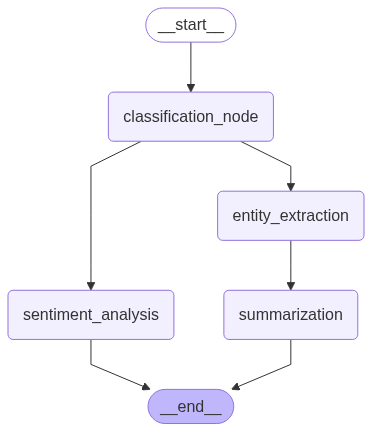

In [ ]:
from IPython.display import Image, display

# Assuming 'app' is your compiled LangGraph object
graph_image = app.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [ ]:
sample_text = """
Model Updates and Security:
 * Gemini 2.5 Pro (experimental): Google has expanded access to its most intelligent experimental model, 2.5 Pro, for all Gemini users.
  This model is noted for its exceptional performance in coding, math, and image understanding.

"""
state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])
print("\nSentiment:", result["sentiment"])

Classification: Blog

Entities: ['Gemini', 'Google']

Summary: Google has made its powerful experimental AI model, Gemini 2.5 Pro, available to all Gemini users, offering enhanced capabilities in coding, math, and image understanding.

Sentiment: positive


In [ ]:
sample_text = """
Security Research: Recent research has demonstrated a proof-of-concept hack where malicious prompts in Google Calendar invites could be used to control connected smart home devices through the Gemini assistant.
 While Google has stated that these types of attacks are currently "exceedingly rare," they are using the findings to improve their defenses against such vulnerabilities.
"""
state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])
print("\nSentiment:", result["sentiment"])

Classification: Research

Entities: ['Google', 'Google Calendar', 'Gemini']

Summary: Malicious Google Calendar invites could potentially control smart home devices via Gemini, prompting Google to improve security despite the current rarity of such attacks.

Sentiment: positive


In [ ]:
sample_text = """
Enhanced Learning Features:
 * Guided Learning: Gemini has introduced a new "Guided Learning" mode designed to help users build a deeper understanding of complex topics. Instead of just giving a quick answer,
  it guides you through subjects step-by-step, breaking down concepts and providing interactive help.
"""
state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])
print("\nSentiment:", result["sentiment"])

Classification: Blog

Entities: ['Gemini,']

Summary: Gemini's new "Guided Learning" mode offers step-by-step, interactive instruction to facilitate deeper understanding of complex topics.

Sentiment: positive


In [ ]:
sample_text = """
Integrated Visuals: To make the learning experience more engaging, Gemini now automatically integrates high-quality images, diagrams,
 and YouTube videos directly into its responses when you ask about complex topics.
"""
state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])
print("\nSentiment:", result["sentiment"])

Classification: Blog

Entities: ['Gemini', 'YouTube']

Summary: Gemini enhances learning by automatically adding relevant visuals like images, diagrams, and videos to its responses.

Sentiment: positive


In [ ]:
sample_text = """
 Competitive Events:
 * Google's Kaggle Game Arena project recently hosted an AI chess exhibition tournament featuring several leading LLMs, including different versions of Gemini. This competition aims to evaluate how general-purpose
 AI models perform in strategic games and has highlighted the varying strengths and weaknesses of different AIs
"""
state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])
print("\nSentiment:", result["sentiment"])

Classification: **News**

**Reasoning:**

The text describes a recent event (Google's Kaggle Game Arena AI chess tournament) and its purpose (evaluating AI models). It presents factual information about the competition and the AI models involved. This aligns with the characteristics of a news report.

Entities: ['Google', 'Kaggle', 'Gemini']

Summary: A recent AI chess tournament on Google's Kaggle Game Arena showcased the varying performance of leading LLMs like Gemini in strategic gameplay.

Sentiment: negative
